In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as ps
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("divorce_data.csv", sep=";")
# Drop rows that contain null
df.dropna()
# Divorce columns need to be inverted: 1 should mean divorced and 0 should mean not divorced
df.Divorce = df.Divorce.map({0:1, 1:0})
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,0
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,0
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,0
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,0
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,0


Text(0.5, 1.0, 'Not Divorced vs Divorced')

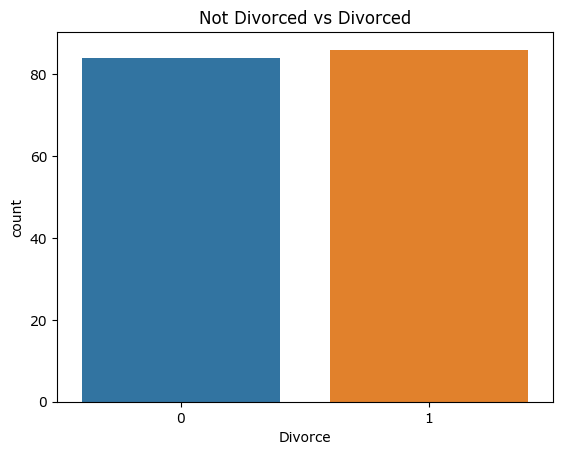

In [3]:
sns.countplot(data=df, x="Divorce").set_title("Not Divorced vs Divorced")

<AxesSubplot: title={'center': 'Predictive Power Score Plot'}, xlabel='x', ylabel='y'>

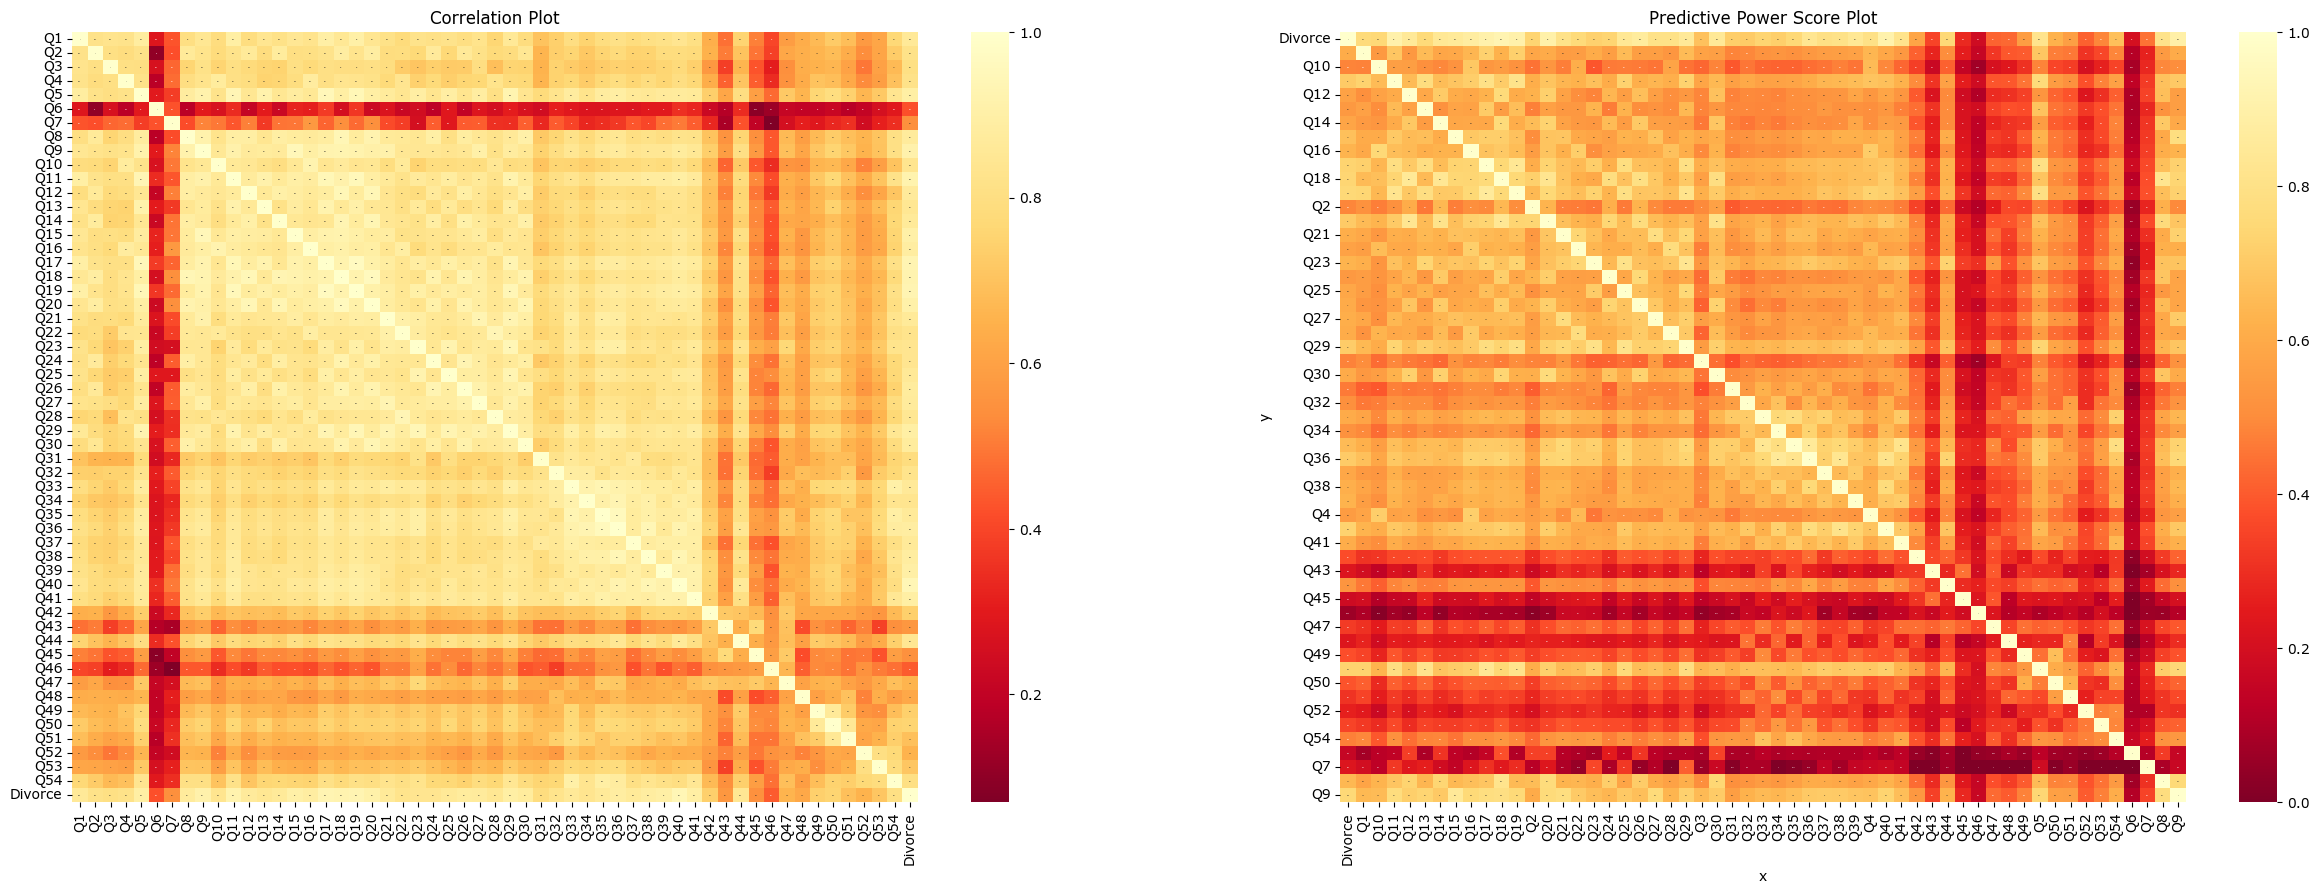

In [4]:
# Make Correlation and Predictive Power Score Plots
corr = df.corr().abs()
plt.figure(figsize=(30,10));plt.subplot(121, title = 'Correlation Plot')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'size': 0}, cmap='YlOrRd_r')
plt.subplot(122, title='Predictive Power Score Plot')
matrix_df = ps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, annot=True, annot_kws={'size': 0}, cmap='YlOrRd_r')

In [5]:
# Too many features; Take only the features most correlated to Divorce
corr_target = corr['Divorce']
pps_target = matrix_df['Divorce']
pps_target = pps_target[pps_target > 0.7]
target = pps_target[corr_target > 0.8]
target_features = list(target.keys())
print(corr_target)
print(pps_target)
print(target_features)

Q1         0.861324
Q2         0.820774
Q3         0.806709
Q4         0.819583
Q5         0.893180
Q6         0.420913
Q7         0.544835
Q8         0.869569
Q9         0.912368
Q10        0.834897
Q11        0.918386
Q12        0.868983
Q13        0.844743
Q14        0.864316
Q15        0.901220
Q16        0.886260
Q17        0.929346
Q18        0.923208
Q19        0.928627
Q20        0.907008
Q21        0.864519
Q22        0.825938
Q23        0.837504
Q24        0.839392
Q25        0.857052
Q26        0.872868
Q27        0.869788
Q28        0.846606
Q29        0.892954
Q30        0.874531
Q31        0.792607
Q32        0.829056
Q33        0.861328
Q34        0.835167
Q35        0.862624
Q36        0.886497
Q37        0.863597
Q38        0.883311
Q39        0.896180
Q40        0.938684
Q41        0.894356
Q42        0.739629
Q43        0.566242
Q44        0.847336
Q45        0.546450
Q46        0.443465
Q47        0.656409
Q48        0.619830
Q49        0.740704
Q50        0.755248


In [6]:
# Drop all other columns
df = df.drop(df.columns.difference(target_features), axis=1)
df.head()

,Q5,Q9,Q17,Q18,Q19,Q20,Q29,Q36,Q40,Divorce
0,0,0,0,0,0,1,0,1,3,0
1,4,4,4,4,3,2,1,2,4,0
2,1,1,3,3,3,2,3,1,3,0
3,3,3,3,3,3,4,1,1,4,0
4,1,0,1,1,2,1,1,0,1,0


<AxesSubplot: title={'center': 'Predictive Power Score Plot'}, xlabel='x', ylabel='y'>

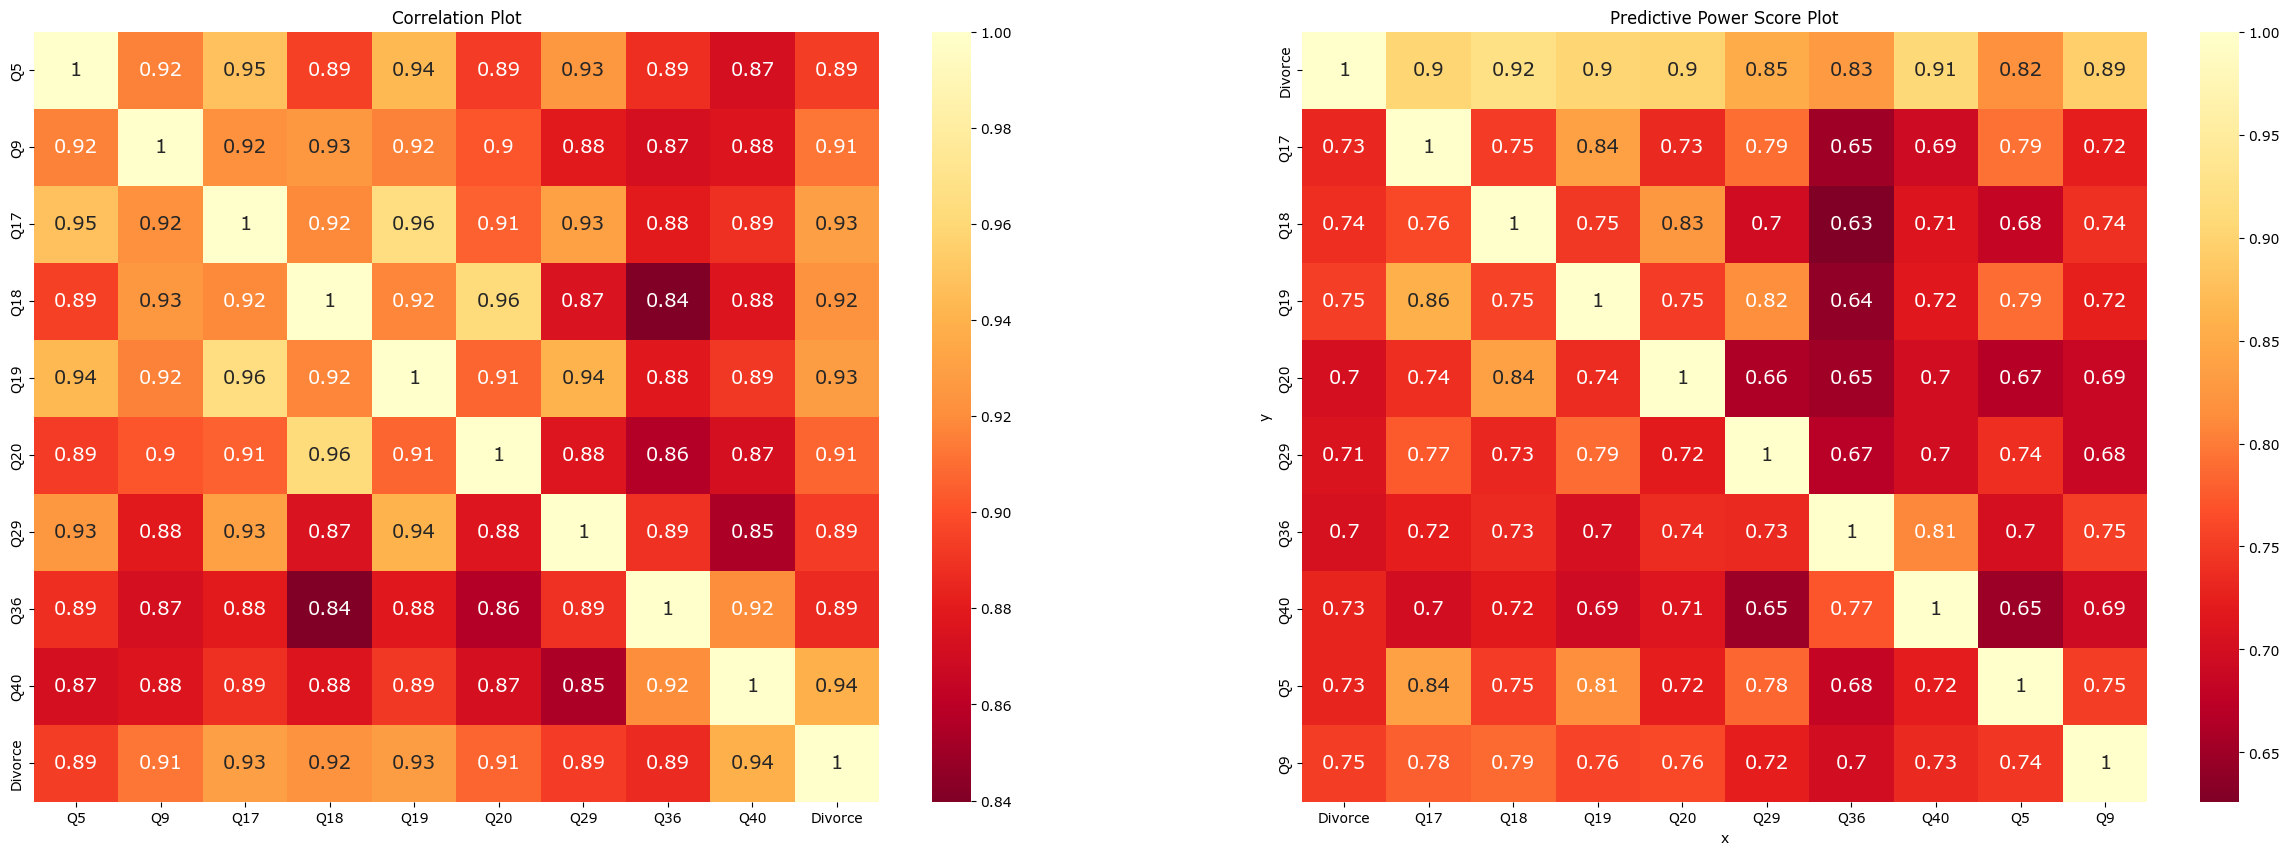

In [7]:
# Make new Correlation and Predictive Power Score Plots
corr = df.corr().abs()
plt.figure(figsize=(30,10));plt.subplot(121, title = 'Correlation Plot')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'size': 14}, cmap='YlOrRd_r')
plt.subplot(122, title='Predictive Power Score Plot')
matrix_df = ps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, annot=True, annot_kws={'size': 14}, cmap='YlOrRd_r')

In [8]:
# Some features are very correlated. Remove any redundant features to finalize selection
redundant_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if corr.iloc[i, j] > 0.95:
            redundant_features.add(corr.columns[i])

df = df.drop(redundant_features, axis=1)
df.head()

,Q5,Q9,Q17,Q18,Q29,Q36,Q40,Divorce
0,0,0,0,0,0,1,3,0
1,4,4,4,4,1,2,4,0
2,1,1,3,3,3,1,3,0
3,3,3,3,3,1,1,4,0
4,1,0,1,1,1,0,1,0


In [9]:
from sklearn.model_selection import train_test_split

# Drop predicting variable Divorce into y
X = df.drop(columns=['Divorce'],axis=1) 
y = df.Divorce

# Create model training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Train Logistic Regression Model
lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)

print('Accuracy in Train set: {:.2f}'.format(lr.score(X_train, y_train)), 
      'Accuracy in Test set: {:.2f}'.format(lr.score(X_test, y_test)), sep='\n')
y_predict = lr.predict(X_test)
print('Accuracy of Predict: {:.2f}'.format(accuracy_score(y_test, y_predict)))

Accuracy in Train set: 0.98
Accuracy in Test set: 1.00
Accuracy of Predict: 1.00


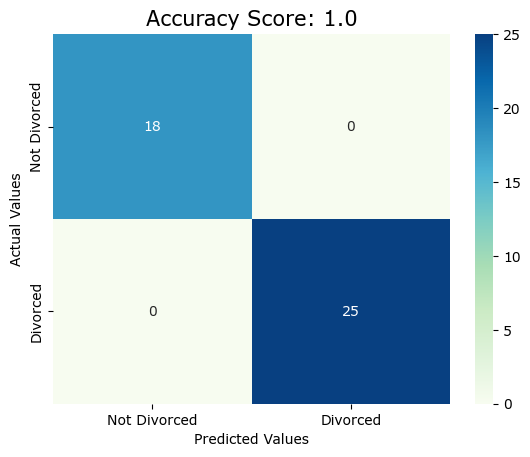

In [11]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, xticklabels=['Not Divorced','Divorced'], yticklabels=['Not Divorced','Divorced'], annot=True, fmt=".0f", cmap='GnBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(accuracy_score(y_test, y_predict)), size = 15)
plt.show()

In [12]:
from sklearn import tree

# Train Decision Tree model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

print('Accuracy in Train set: {:.2f}'.format(clf.score(X_train, y_train)), 
      'Accuracy in Test set: {:.2f}'.format(clf.score(X_test, y_test)), sep='\n')

Accuracy in Train set: 1.00
Accuracy in Test set: 0.98


Accuracy of Predict: 0.98


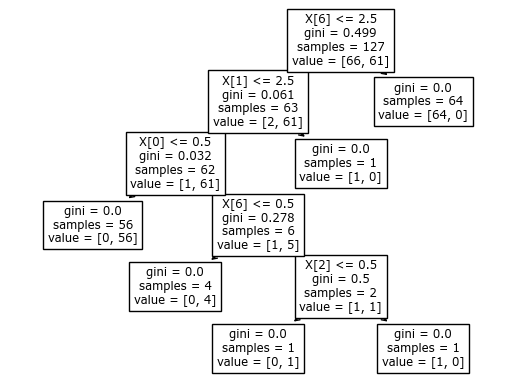

In [13]:
tree.plot_tree(clf)
y_predict = clf.predict(X_test)
print('Accuracy of Predict: {:.2f}'.format(accuracy_score(y_test, y_predict)))

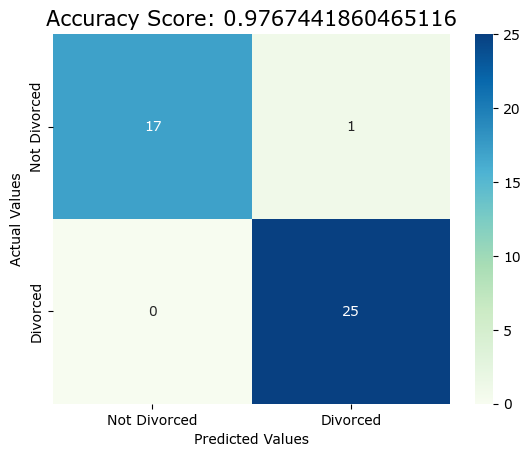

In [14]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, xticklabels=['Not Divorced','Divorced'], yticklabels=['Not Divorced','Divorced'], annot=True, fmt=".0f", cmap='GnBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(accuracy_score(y_test, y_predict)), size = 15)
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier

#Train Random Forest Model
clf = RandomForestClassifier(random_state=13)
clf.fit(X_train, y_train)

print('Accuracy in Train set: {:.2f}'.format(clf.score(X_train, y_train)), 
      'Accuracy in Test set: {:.2f}'.format(clf.score(X_test, y_test)), sep='\n')
y_predict = clf.predict(X_test)
print('Accuracy of Predict: {:.2f}'.format(accuracy_score(y_test, y_predict)))

Accuracy in Train set: 1.00
Accuracy in Test set: 0.98
Accuracy of Predict: 0.98


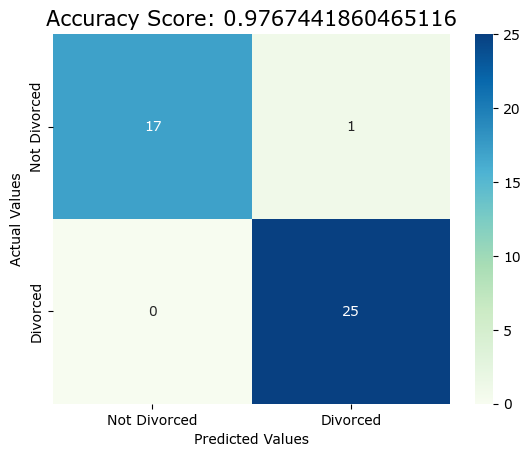

In [16]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, xticklabels=['Not Divorced','Divorced'], yticklabels=['Not Divorced','Divorced'], annot=True, fmt=".0f", cmap='GnBu')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(accuracy_score(y_test, y_predict)), size = 15)
plt.show()